# Project: Investigate a Dataset - No-Show Apointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<style>
  table {margin-left: 0 !important;}
</style>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 

The dataset selected is the "No-Show Apointments" dataset. The dataset includes data from over 100,000 appointments in Brazil and whether or not they show up to the scheduled appointments.

Objective of the analysis is to find trends which could help us predict if the pateint will show up to the apointment or not. 

The dataset set consists of one table with the following variables.


| PatientId | AppointmentID | Gender | ScheduledDay | AppointmentDay |	Age |	Neighbourhood |	Scholarship |	Hipertension |	Diabetes |	Alcoholism |	Handcap	| SMS_received | No-show
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| ID number for the Patient | Unqiue ID for every apointment | Patient Gender | Day appointment was scheduled for | Actual date of appointment | Patient Age | Neighbourhood | Enrollment in Bolsa Familia | Patient Hypertension | Patient Diabetes | Patient Alcoholism  | Patient Hadicapped | Received SMS Notification | Patient did not show up to the appointment on time |


### Question(s) for Analysis

To be able to predict whether or not a patient will show up to the appointment on time, the following quations are being investigated.

Are the no-show events related to some patient's characteristics such as age, gender, neighbourhood or disease?

Were SMS reminders sucesful in getting pateints to show up to the appointments?

To build above table used help from https://stackoverflow.com/questions/48655801/tables-in-markdown-in-jupyter

Started by importing needed packages such as pandas, matplotlib and sns. datetime was also added to handle the Schedule Date and Appoitment Data data that were initially saved as strings.

In [1491]:
# This cell has been used to import important packages to be used in the analysis.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from datetime import datetime

This step was also done based on the template recommendation, then the cell converted to markdown.

!pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling


### Gathering Data

In [1492]:
# Reading the csv file.
df = pd.read_csv('Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [1493]:
df.shape

(110527, 14)

In [1494]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Investigating the dataset, seems there are no null or missing data. The data is quite clean.

The No-Show column seems to be string type while the disease are all integers.

Dates are strings and need to be converted to a proper date/time format.

In [1495]:
df.duplicated().sum()

0

There are no duplicate rows. Checking if the supposedly unique values are truly unique. Check if there duplicateds in Apointment ID.

In [1496]:
df.duplicated(subset=['AppointmentID']).sum()

0

In [1497]:
df.duplicated(subset=['AppointmentDay']).sum()

110500

In [1498]:
df.duplicated(subset=['PatientId']).sum()

48228

In [1499]:
df['PatientId'].nunique()

62299

In [1500]:
df['PatientId'].value_counts().max()

88

Found the Apointment ID to be unique for every row which is expected.

Patient ID has duplications indicating that recurring patients are probably tracked correctly. Found 62,299 unique PatientID entries. To check there are no specific value of PatientId occuring too many times, also found maximum times of occurance of one PatienID and found it 88. 

Second check to ensure cleanliness: For example that there is only one gender listed for every unique PatientId. Found also there is only one neighbourhood listed per PatientId.

In [1501]:
(df.groupby('PatientId')['Gender'].nunique() == 1).all()

True

In [1502]:
(df.groupby('PatientId')['Neighbourhood'].nunique() == 1).all()

True

Investigating dataset values

In [1503]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Scholarhsip, diseases and SMS_received values seems to have only 0 or 1 (will assume 0 means the absense of the characteristic). 
Handicapped can take upto 4 values, will assume 0 means not handicapped while 1 - 3 indicate the severity of being disabled/handicapped.
It seems that the age distribution is not correct. the age starts with -1 which need investigation and also max value is 115.

Run a historam to have a visual look on the data

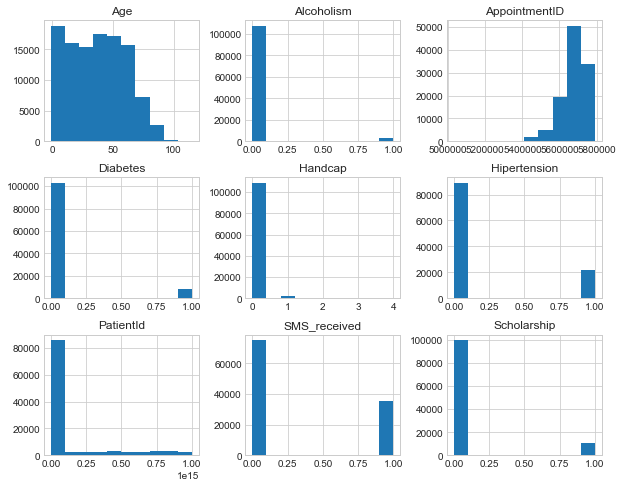

In [1504]:
df.hist(figsize=(10,8));
sns.set_style('whitegrid')

Note: The patient ID histogram is highly skewed to the right as it seems most IDs have small values and number of bins is only 10 while there are more than 62000 unqiue values.


### Data Cleaning


Start by identifying whihc record has Age less than zero ot more than 100.

In [1505]:

df[df['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [1506]:
df[df['Age']>100]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
58014,9.762948e+14,5651757,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


Investigating the Age < 0 entries found just one so will be dropped. Investigating Age > 100 entries found 5 entries of Age 115 which are also very suspicious so will also be dropped. Used assistance from https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/ to drop these values.

In [1507]:
df.drop(df[df['Age'] < 0].index, inplace = True)
(df['Age']<0).any()

False

In [1508]:
df.drop(df[df['Age'] == 115].index, inplace = True)
(df['Age'] == 115).any()

False

Dropped entries where the age value is not correct.

As the Apointment ID appears to have no additional value to our analysis if will be dropped.

In [1509]:
df.drop(['AppointmentID'], axis=1, inplace=True)

In [1510]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [1511]:
df.shape

(110521, 13)

Upcoming Task is to convert the date and time strings to be in datetime format.

In [1512]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format='%Y-%m-%dT%H:%M:%SZ')
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format='%Y-%m-%dT%H:%M:%SZ')
df.head(10)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,F,2016-04-27 08:36:51,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,F,2016-04-27 15:05:12,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,F,2016-04-27 15:39:58,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,F,2016-04-29 08:02:16,2016-04-29,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,F,2016-04-27 12:48:25,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,No


Also will convert the No-Show to Boolean for ease of search and analysis. 

Used help from https://stackoverflow.com/questions/17702272/convert-pandas-series-containing-string-to-boolean.

In [1513]:
no_show = {
  'Yes': True,
  'No': False
}
df['No-show'] = df['No-show'].map(no_show)

In [1514]:
df.head(6)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,False
1,5.589978e+14,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,False
2,4.262962e+12,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,False
3,8.679512e+11,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,False
4,8.841186e+12,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,False
5,9.598513e+13,F,2016-04-27 08:36:51,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,False


Cleaning done:
- Rows with unrealistic Ages were removed
- Apoitment ID has no value, column has been dropped
- No-show has been converted to boolean 
- Date columns format look good.


It appears that AppoinmentDay has no realistic value for time, when check if the date value is always consistent with ScheduledDay, it appears there is soemtimes a discrepancy. The realtionship between AppointmentDay, ScheduledDay and No-show was investigated.

In [1515]:
(df['ScheduledDay'].dt.date == df['AppointmentDay'].dt.date).all()

False

In [1516]:
df['late_duration'] = df['AppointmentDay'].dt.date - df['ScheduledDay'].dt.date

In [1517]:
early_date = df[df['AppointmentDay'].dt.date < df['ScheduledDay'].dt.date]
early_date.shape[0]

5

In [1518]:
early_date['No-show'].sum()

5

In [1519]:
right_date = df[df['AppointmentDay'].dt.date == df['ScheduledDay'].dt.date]
right_date.shape[0]

38561

In [1520]:
right_date['No-show'].sum()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


1792

In [1521]:
late_date = df[df['AppointmentDay'].dt.date > df['ScheduledDay'].dt.date]
late_date.shape[0]

71955

In [1522]:
late_date['No-show'].sum()

20519

In [1523]:
late_date['late_duration'].mean()

Timedelta('15 days 15:24:34.671669')

In [1524]:
late_date[late_date['No-show']]['late_duration'].mean()

Timedelta('17 days 05:14:49.341585')

On 5 occasions AppointmentDay was less than ScheduledDay indicating the patients have actually came earlier than planned. The patients in this case are still marked as no show.

On 38,561 occasions the AppointmentDay was equal to ScheduledDay. 1,792 of them still counted as no-show as they probably did not come at the right appointment time.

On 71,955 occasions AppointmentDay was more than ScheduledDay indicating the patients have came later than planned. Only 20,519 of these occasions are counted as No-show though. The rest are assumed to have res-scheduled their appointments.

It appears people are late **most of the time** with a mean time of **more than 15 days!**

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: Are the no-show events related to some patient's characteristics such as age, gender or disease?

First let's have a look on the Patient data with and without no-show flags

In [1525]:
noshows = df[df['No-show']]
noshows.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,late_duration
count,2.231600e+04,22316.000000,22316.000000,22316.000000,22316.00000,22316.000000,22316.000000,22316.000000,22316
mean,1.467677e+14,34.306820,0.115522,0.169027,0.06408,0.030337,0.020165,0.438430,15 days 19:57:34.167413
std,2.550042e+14,21.947486,0.319659,0.374784,0.24490,0.171517,0.156268,0.496206,16 days 14:32:31.538194
min,5.628261e+06,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-6 days +00:00:00
25%,4.176779e+12,16.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4 days 00:00:00
50%,3.154340e+13,33.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,11 days 00:00:00
75%,9.454369e+13,51.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,23 days 00:00:00
max,9.996585e+14,98.000000,1.000000,1.000000,1.00000,1.000000,4.000000,1.000000,179 days 00:00:00


In [1526]:
ontimes = df[df['No-show'] == False]
ontimes.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,late_duration
count,8.820500e+04,88205.000000,88205.000000,88205.000000,88205.000000,88205.000000,88205.000000,88205.000000,88205
mean,1.476754e+14,37.788753,0.093906,0.204388,0.073839,0.030418,0.022731,0.291333,8 days 18:06:53.609205
std,2.563686e+14,23.336014,0.291700,0.403256,0.261511,0.171735,0.162719,0.454379,14 days 13:12:49.278722
min,3.921784e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
25%,4.168386e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
50%,3.175832e+13,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2 days 00:00:00
75%,9.433654e+13,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12 days 00:00:00
max,9.999816e+14,102.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179 days 00:00:00


The above are the statistcs of no-show and on-time appointments.

In [1527]:
noshows.shape[0] + ontimes.shape[0] == df.shape[0]

True

Make a check that the sum of both rows is the inital data frame.

Now lets investigate the statistics of the patient characteristics in both tables.

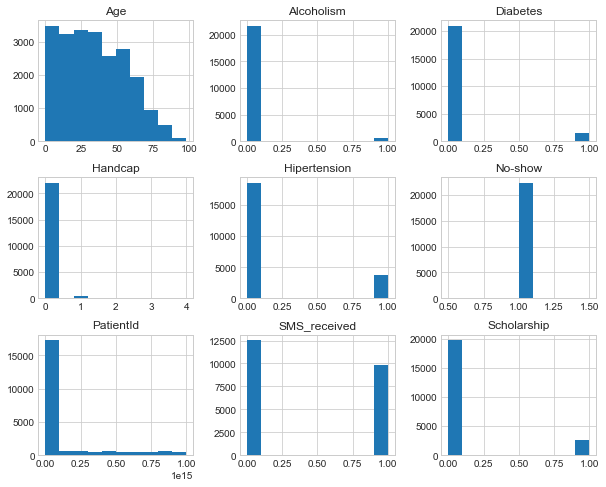

In [1528]:
noshows.hist(figsize=(10,8));

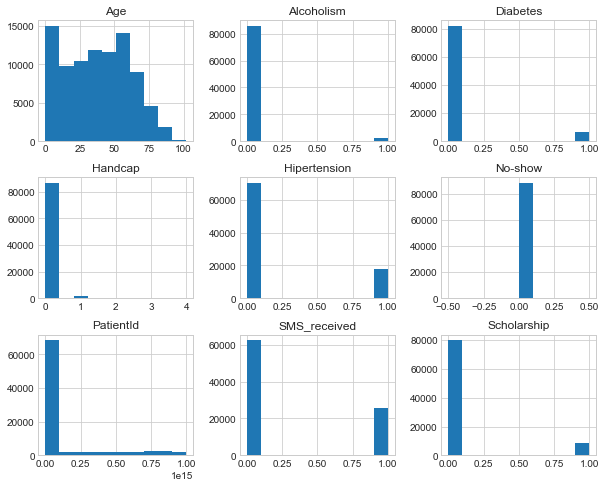

In [1529]:
ontimes.hist(figsize=(10,8));

Plotted histograms for appointments marked as no-show and not marked as no-show. 

For many variables, the distributions are not highly different. It is hard to draw a conclusion this way. It would be better to look and investigate the ratio of no-shows considering each variable separately.

As the ploting of bar charts is going to be used several times, this function was developed to achieve that in a quick way.

In [1530]:
def barplot(data, label, tickmarks = ['No', 'Yes', 'Severe','Higher Severity','Highest Severity']):
    '''This function helps plotting a bar chart of No-Show rates based on every patient characteristic given the data to be plotted and the label for the X-Axis. '''
    myplot = data.plot.bar()
    myplot.set_title('No-Show to Appointments based on {}'.format(label))
    myplot.set_xlabel(label)
    myplot.set_ylabel('No-Show Ratios')
    myplot.set_xticklabels(tickmarks)

getrate function also calculates the no-show rate for every characteristic.

In [1531]:
def getrate(col):
    ''' This function calculates the No-Show rate for any given patient characteristic.'''
    return df.groupby(col)['No-show'].sum() / df.groupby(col)['No-show'].count()

#### Patient ID

Investigating if the no-show events are related to specific patients.

In [1532]:
patientid_noshow_rate = getrate('PatientId')
#patientid_noshow_rate = df.groupby('PatientId')['No-show'].sum() / df.groupby('PatientId')['No-show'].count()
patientid_noshow_rate.describe()

count    62296.000000
mean         0.196427
std          0.351418
min          0.000000
25%          0.000000
50%          0.000000
75%          0.333333
max          1.000000
Name: No-show, dtype: float64

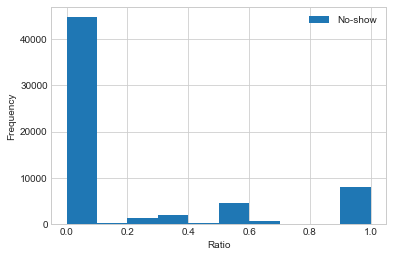

In [1533]:
hist = patientid_noshow_rate.plot.hist()
hist.set_xlabel('Ratio')
plt.legend();

Some patients have really high no-show rates even reaching 100%!

In [1534]:
patientid_noshow_rate[patientid_noshow_rate > 0.5]

PatientId
5.628261e+06    1.000000
1.224513e+08    1.000000
1.798748e+08    1.000000
2.157787e+08    1.000000
3.424788e+08    1.000000
4.117772e+08    1.000000
4.832779e+08    1.000000
4.867367e+08    1.000000
5.225847e+08    1.000000
5.733979e+08    1.000000
5.891944e+08    1.000000
6.469579e+08    1.000000
6.723485e+08    1.000000
7.532614e+08    1.000000
8.959992e+08    1.000000
9.112637e+08    1.000000
1.414672e+09    1.000000
1.475697e+09    1.000000
1.671348e+09    1.000000
1.731655e+09    1.000000
1.764922e+09    1.000000
2.173198e+09    1.000000
2.177193e+09    1.000000
2.533277e+09    1.000000
2.545273e+09    1.000000
2.684594e+09    1.000000
2.787316e+09    1.000000
2.824113e+09    1.000000
2.846559e+09    1.000000
2.862722e+09    1.000000
                  ...   
9.879662e+14    1.000000
9.881399e+14    1.000000
9.881986e+14    1.000000
9.882116e+14    1.000000
9.882852e+14    1.000000
9.888778e+14    1.000000
9.891688e+14    1.000000
9.898626e+14    1.000000
9.899638e+14   

While most of the Patients have a low rate of no show others have a consistent trend of not showing up to the appointments. The first prediction to check if the patient will end up not showing up to the appoitment if he/she has missed all or most of the appointments before (one of the Patients in the above list).

Hence, **if the patient is from the above list it is likely he/she will miss next appointment.**

#### Gender

In [1535]:
gender_noshow_rate = getrate('Gender')
#gender_noshow_rate = df.groupby('Gender')['No-show'].sum() / df.groupby('Gender')['No-show'].count()
gender_noshow_rate

Gender
F    0.203121
M    0.199679
Name: No-show, dtype: float64

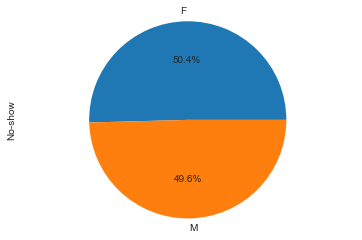

In [1536]:
normalized = gender_noshow_rate / gender_noshow_rate.sum()
normalized
pieplot = normalized.plot.pie(autopct='%1.1f%%')
pieplot.axis('equal');

While Females have a slightly higher rate of no-show, the rates for males and females no-show are very close.

**We cannot prredict no-show event by Gender.**

### Age

In [1537]:
age_noshow_rate = getrate('Age')
#age_noshow_rate = df.groupby('Age')['No-show'].sum() / df.groupby('Age')['No-show'].count()
age_noshow_rate.describe()

count    102.000000
mean       0.188731
std        0.053665
min        0.000000
25%        0.161550
50%        0.185880
75%        0.227088
max        0.282648
Name: No-show, dtype: float64

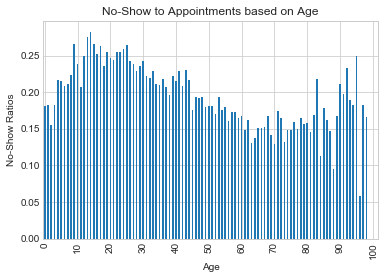

In [1538]:
tickmarks = np.arange(0,102,10)
myplot = age_noshow_rate.plot.bar()
myplot.set_title('No-Show to Appointments based on Age')
myplot.set_xlabel('Age')
myplot.set_ylabel('No-Show Ratios')
plt.xticks(tickmarks, tickmarks);

It appears the highest ages of showing high no-show rates are patietns between 10-30 years old.

In [1539]:
age_top_noshow = age_noshow_rate[age_noshow_rate > age_noshow_rate.quantile(0.75)]
age_top_noshow

Age
9     0.265306
10    0.238619
12    0.249084
13    0.274705
14    0.282648
15    0.265896
16    0.251783
17    0.262425
18    0.235373
19    0.255016
20    0.247042
21    0.244490
22    0.255087
23    0.254262
24    0.258454
25    0.264264
26    0.243180
27    0.238925
28    0.229282
29    0.235210
30    0.242604
33    0.228346
41    0.228826
43    0.229911
92    0.232558
95    0.250000
Name: No-show, dtype: float64

It appears ages group of 9 to 30 years have the most occurance of high no-show rates.

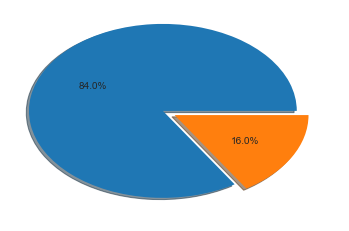

In [1540]:
ratio_age_below30 = pd.Series([age_top_noshow[:21].count(),age_top_noshow[22:].count()])
plt.pie(ratio_age_below30, shadow = True, autopct='%1.1f%%',explode = (0.1,0));

**Highest No-Show Rates appear mostly at age 9 - 30.** This age group represents 84% of the patients with high no shows rates. There are 2 ages in the highest quartile from the age group above 90 years so will isnpect the trend in the age group.

In [1541]:
age_noshow_rate[90:]

Age
90     0.211009
91     0.196970
92     0.232558
93     0.188679
94     0.181818
95     0.250000
96     0.058824
97     0.181818
98     0.166667
99     0.000000
100    0.000000
102    0.000000
Name: No-show, dtype: float64

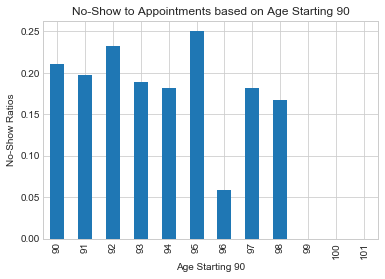

In [1542]:
tickmarks = np.arange(90,103)
barplot(age_noshow_rate[90:], 'Age Starting 90', tickmarks)

Except the age of 96, Ages from 90 to 98 have somehow similar no-show rates.

### Scholarship

In [1543]:
scholarship_noshow_rate = getrate('Scholarship')
#scholarship_noshow_rate = df.groupby('Scholarship')['No-show'].sum() / df.groupby('Scholarship')['No-show'].count()
scholarship_noshow_rate

Scholarship
0    0.198053
1    0.237363
Name: No-show, dtype: float64

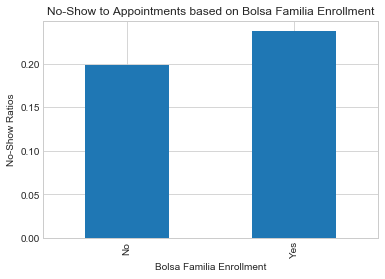

In [1544]:
barplot(scholarship_noshow_rate, 'Bolsa Familia Enrollment')

It appears **being enrolled in Bolsa Familia corrlates with an increases in missing the appointment.**

### Hyper Tension

In [1545]:
hipertension_noshow_rate = getrate('Hipertension')
#hipertension_noshow_rate = df.groupby('Hipertension')['No-show'].sum() / df.groupby('Hipertension')['No-show'].count()
hipertension_noshow_rate

Hipertension
0    0.209015
1    0.173028
Name: No-show, dtype: float64

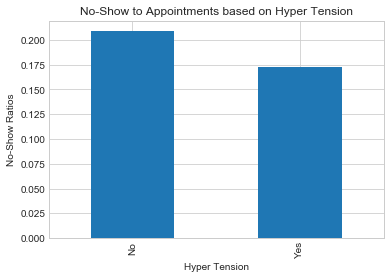

In [1546]:
barplot(hipertension_noshow_rate, 'Hyper Tension')

The presense of **hyper tension disease correlates with reduction in the no-show rate.**

### Diabetes

In [1547]:
diabetes_noshow_rate = getrate('Diabetes')
#diabetes_noshow_rate = df.groupby('Diabetes')['No-show'].sum() / df.groupby('Diabetes')['No-show'].count()
diabetes_noshow_rate

Diabetes
0    0.203611
1    0.180033
Name: No-show, dtype: float64

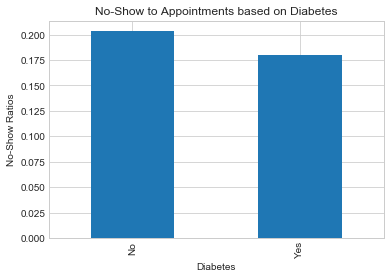

In [1548]:
barplot(diabetes_noshow_rate, 'Diabetes')

The presense of **diabetes disease reduces the chance of missing the appoitment.**

### Alcoholism

In [1549]:
alcoholism_noshow_rate = getrate('Alcoholism')
#alcoholism_noshow_rate = df.groupby('Alcoholism')['No-show'].sum() / df.groupby('Alcoholism')['No-show'].count()
alcoholism_noshow_rate

Alcoholism
0    0.201930
1    0.201488
Name: No-show, dtype: float64

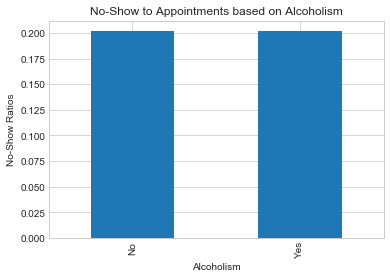

In [1550]:
barplot(alcoholism_noshow_rate, 'Alcoholism')

**Alcoholism has no apprent effect on the No-Show statistics.**

### Handicapped

In [1551]:
handicapped_noshow_rate = getrate('Handcap')
#handicapped_noshow_rate = df.groupby('Handcap')['No-show'].sum() / df.groupby('Handcap')['No-show'].count()
handicapped_noshow_rate

Handcap
0    0.202357
1    0.178116
2    0.202186
3    0.230769
4    0.333333
Name: No-show, dtype: float64

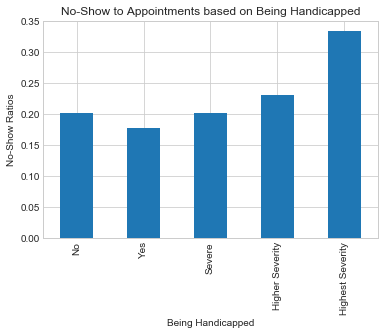

In [1552]:
barplot(handicapped_noshow_rate, 'Being Handicapped')

Although the handicapped patients having handicapped score of 1 has a lower rate of no-show that the not disabled, the **higher severity of being handicapped shows the highest rate of no-show**

### Neighberhood

In [1553]:
neighbourhood_noshow_rate = getrate('Neighbourhood')
#neighbourhood_noshow_rate = df.groupby('Neighbourhood')['No-show'].sum() / df.groupby('Neighbourhood')['No-show'].count()
neighbourhood_noshow_rate.describe()

count    81.000000
mean      0.205418
std       0.097227
min       0.000000
25%       0.179907
50%       0.197588
75%       0.217454
max       1.000000
Name: No-show, dtype: float64

It appears one neighboorhood has a no-show ratio of 100%!

In [1554]:
neighbourhood_noshow_rate[neighbourhood_noshow_ratio == 1]

Neighbourhood
ILHAS OCEÂNICAS DE TRINDADE    1.0
Name: No-show, dtype: float64

In [1555]:
df[df['Neighbourhood'] == 'ILHAS OCEÂNICAS DE TRINDADE']

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,late_duration
48754,5.349869e+11,F,2016-04-14 12:25:43,2016-05-13,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,True,29 days
48765,7.256430e+12,F,2016-04-14 12:26:13,2016-05-13,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,True,29 days


Investigating more it seems this Neighbourhood only had two appointments. So will ignore the results of it.

In [1556]:
neighbourhood_noshow_rate = neighbourhood_noshow_rate[neighbourhood_noshow_ratio < 1]

In [1557]:
neighbourhood_noshow_rate[neighbourhood_noshow_ratio == 0]

Neighbourhood
PARQUE INDUSTRIAL    0.0
Name: No-show, dtype: float64

In [1558]:
df[df['Neighbourhood'] == 'PARQUE INDUSTRIAL']

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,late_duration
75199,8.255992e+12,F,2016-05-05 10:48:59,2016-05-05,17,PARQUE INDUSTRIAL,0,0,0,0,0,0,False,0 days


Similarly there appears to be only one appointment in the Neighbourhood having 0 No-Show rate.

In [1559]:
neighbourhood_noshow_rate = neighbourhood_noshow_rate[neighbourhood_noshow_ratio > 0]

In [1560]:
neighbourhood_noshow_rate.describe()

count    79.000000
mean      0.197960
std       0.031683
min       0.085714
25%       0.180276
50%       0.197588
75%       0.217026
max       0.289185
Name: No-show, dtype: float64

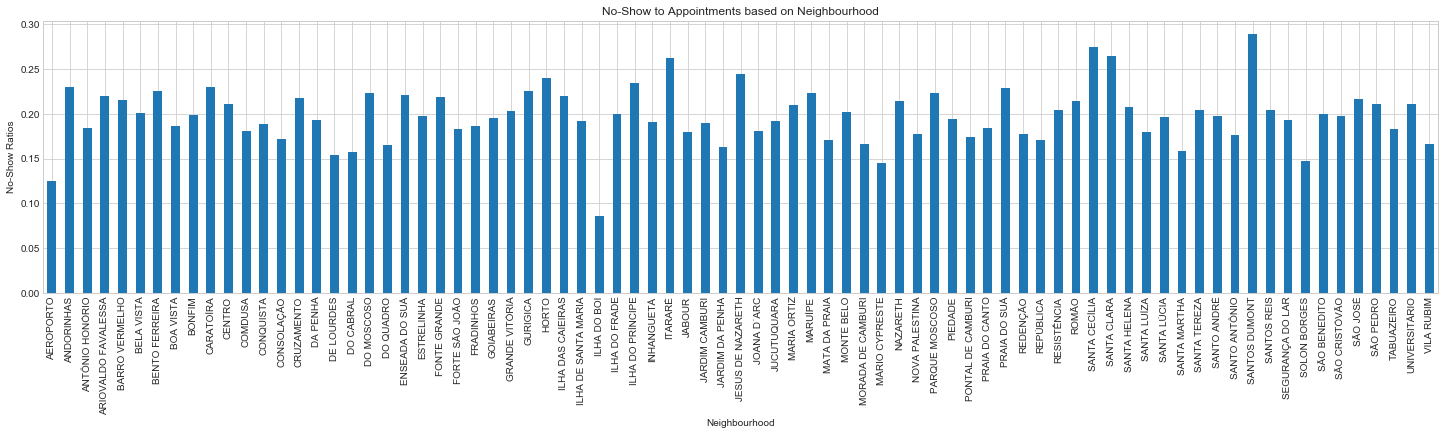

In [1561]:
figure = neighbourhood_noshow_rate.plot(kind = 'bar', figsize = (25,5));
figure.set_title('No-Show to Appointments based on Neighbourhood')
figure.set_ylabel('No-Show Ratios');
#did not use the funtion barchart as to have more control on figure size

In [1562]:
highest_neighboorhoods = neighbourhood_noshow_rate[neighbourhood_noshow_ratio > 0.217]
highest_neighboorhoods

Neighbourhood
ANDORINHAS             0.229407
ARIOVALDO FAVALESSA    0.219858
BENTO FERREIRA         0.224942
CARATOÍRA              0.230409
CRUZAMENTO             0.217454
DO MOSCOSO             0.222760
ENSEADA DO SUÁ         0.221277
FONTE GRANDE           0.218475
GURIGICA               0.225966
HORTO                  0.240000
ILHA DAS CAIEIRAS      0.219421
ILHA DO PRÍNCIPE       0.234775
ITARARÉ                0.262664
JESUS DE NAZARETH      0.243954
MARUÍPE                0.222923
PARQUE MOSCOSO         0.223192
PRAIA DO SUÁ           0.228261
SANTA CECÍLIA          0.274554
SANTA CLARA            0.264822
SANTOS DUMONT          0.289185
Name: No-show, dtype: float64

**Apointments in the above list of neighbourhoods have higher rate of no-shows**

In [1563]:
worst_nb = df[df['Neighbourhood'] == 'SANTOS DUMONT']
worst_nb.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,late_duration
count,1.276000e+03,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276
mean,1.675197e+14,37.744514,0.184169,0.311129,0.109718,0.026646,0.012539,0.351097,12 days 06:24:49.655172
std,2.802037e+14,22.907465,0.387774,0.463137,0.312660,0.161109,0.124615,0.477500,16 days 14:33:45.413896
min,5.733979e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
25%,3.558900e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
50%,2.809030e+13,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5 days 00:00:00
75%,1.160035e+14,56.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,19 days 00:00:00
max,9.986125e+14,95.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,119 days 00:00:00


In [1564]:
df.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,late_duration
count,1.105210e+05,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521
mean,1.474921e+14,37.085694,0.098271,0.197248,0.071869,0.030401,0.022213,0.321034,10 days 04:24:33.472009
std,2.560928e+14,23.104606,0.297682,0.397923,0.258272,0.171690,0.161440,0.466876,15 days 06:07:19.071616
min,3.921784e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6 days +00:00:00
25%,4.172457e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
50%,3.172598e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4 days 00:00:00
75%,9.438963e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15 days 00:00:00
max,9.999816e+14,102.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179 days 00:00:00


The mean age in the worst neighboorhood appears to be not different than the mean of complete dataset. Investigating the characteristics with have a big difference in mean from the complete dataset.

In [1565]:
worst_nb.groupby('Scholarship')['No-show'].sum() / worst_nb.groupby('Scholarship')['No-show'].count()

Scholarship
0    0.292988
1    0.272340
Name: No-show, dtype: float64

In [1566]:
worst_nb.groupby('Hipertension')['No-show'].sum() / worst_nb.groupby('Hipertension')['No-show'].count()

Hipertension
0    0.296928
1    0.272040
Name: No-show, dtype: float64

No conclusion or correlation seen, let's check on the Age distribution.

In [1567]:
age_noshow_worstnb = worst_nb.groupby('Age')['No-show'].sum() / worst_nb.groupby('Age')['No-show'].count()
age_noshow_worstnb.describe()

count    91.000000
mean      0.289468
std       0.187117
min       0.000000
25%       0.170290
50%       0.285714
75%       0.382784
max       1.000000
Name: No-show, dtype: float64

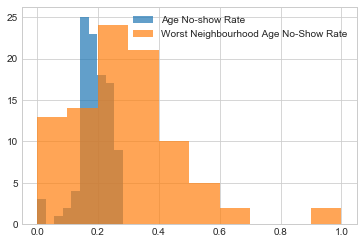

In [1568]:
age_noshow_rate.hist(alpha=0.7, label = 'Age No-show Rate');
age_noshow_worstnb.hist(alpha = 0.7, label = 'Worst Neighbourhood Age No-Show Rate');
plt.legend();

### Research Question 2: Are SMS reminders sucesful in getting pateints to show up to the appointments?

In [1569]:
smsreceived_noshow_rate = getrate('SMS_received')
#smsreceived_noshow_rate = df.groupby('SMS_received')['No-show'].sum() / df.groupby('SMS_received')['No-show'].count()
smsreceived_noshow_rate

SMS_received
0    0.167004
1    0.275753
Name: No-show, dtype: float64

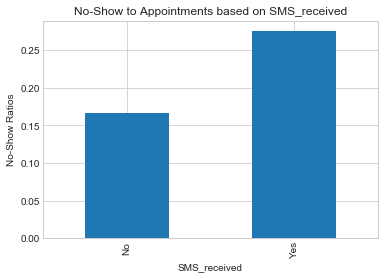

In [1570]:
barplot(smsreceived_noshow_rate, 'SMS_received')

It seesm the **no-show rates of patients who received SMS reminders are actually higher than whose who did not!** Need to investiate the content & timing of the message being sent.

In [1571]:
df.groupby(['SMS_received','Gender'])['No-show'].sum() / df.groupby(['SMS_received','Gender'])['No-show'].count()

SMS_received  Gender
0             F         0.165243
              M         0.170066
1             F         0.277674
              M         0.271631
Name: No-show, dtype: float64

Again no differentiation based on Gender.

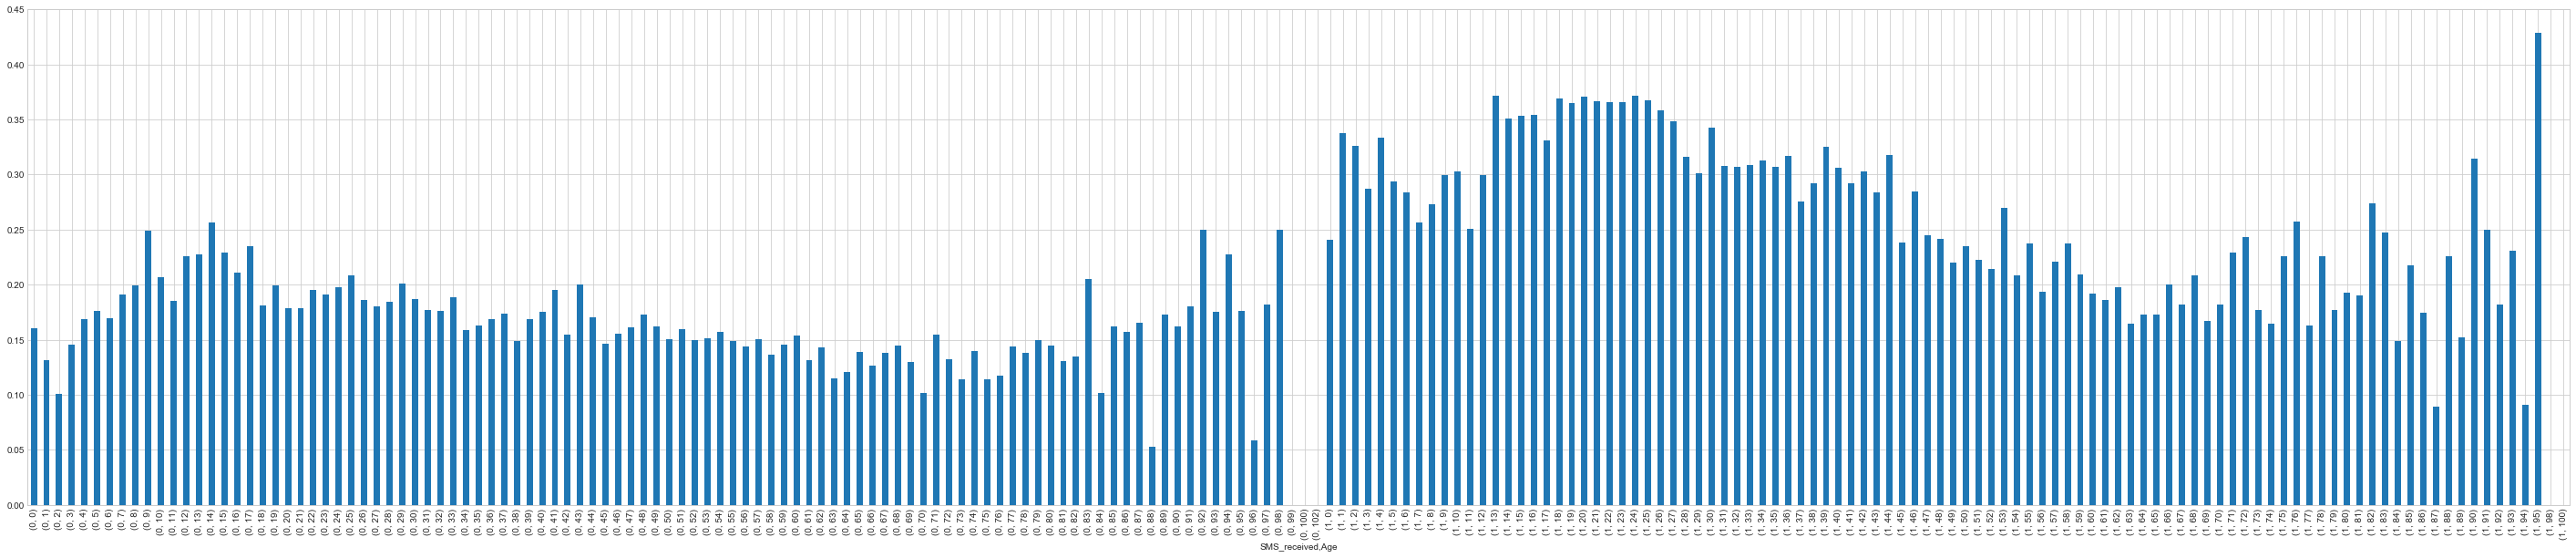

In [1572]:
sms_age = getrate(['SMS_received','Age'])
#sms_age = df.groupby(['SMS_received','Age'])['No-show'].sum() / df.groupby(['SMS_received','Age'])['No-show'].count()
sms_age.plot.bar(figsize = (50,10));


People who reciev SMS have higher no-show eates in general. Howveer, the age distributions look similar on both groups (those who received SMS and those who didn't). let's take a closer look on the very high age and low age.

In [1573]:
high_age = df[df['Age']>80]
high_age

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,late_duration
38,5.873316e+12,M,2016-04-20 15:54:18,2016-04-29,85,SÃO CRISTÓVÃO,0,1,0,0,0,1,False,9 days
190,9.458118e+09,M,2016-04-29 10:56:40,2016-04-29,81,CONQUISTA,0,0,0,0,1,0,False,0 days
243,4.414318e+14,F,2016-04-29 08:49:15,2016-04-29,89,CARATOÍRA,0,1,0,0,0,0,False,0 days
296,9.984591e+13,F,2016-04-29 10:08:47,2016-04-29,83,ILHA DE SANTA MARIA,0,0,0,0,0,0,False,0 days
402,1.883563e+12,F,2016-04-26 16:23:49,2016-04-29,87,SOLON BORGES,0,0,0,0,0,0,False,3 days
532,2.824892e+13,M,2016-04-29 08:58:01,2016-04-29,83,ITARARÉ,0,0,0,0,0,0,False,0 days
592,3.236689e+14,F,2016-03-22 07:42:35,2016-04-29,83,ITARARÉ,0,0,0,0,0,1,False,38 days
626,7.132173e+14,F,2016-04-28 10:20:49,2016-04-29,88,CARATOÍRA,0,1,0,0,0,0,False,1 days
642,5.147594e+14,M,2016-04-29 09:23:07,2016-04-29,81,PRAIA DO CANTO,0,0,0,0,0,0,False,0 days
656,4.516349e+13,F,2016-04-15 11:14:03,2016-04-29,89,CENTRO,0,0,1,0,0,0,False,14 days


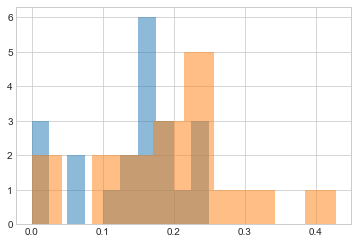

In [1574]:
sms_high_age = high_age.groupby(['SMS_received','Age'])['No-show'].sum() / high_age.groupby(['SMS_received','Age'])['No-show'].count()
sms_high_age[0].hist(alpha=0.5);
sms_high_age[1].hist(alpha=0.5);

In [1575]:
low_age = df[df['Age']<30]
low_age

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,late_duration
3,8.679512e+11,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,False,0 days
6,7.336882e+14,F,2016-04-27 15:05:12,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,True,2 days
8,5.639473e+13,F,2016-04-29 08:02:16,2016-04-29,21,ANDORINHAS,0,0,0,0,0,0,False,0 days
9,7.812456e+13,F,2016-04-27 12:48:25,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,False,2 days
11,7.542951e+12,M,2016-04-26 08:44:12,2016-04-29,29,NOVA PALESTINA,0,0,0,0,0,1,True,3 days
12,5.666548e+14,F,2016-04-28 11:33:51,2016-04-29,22,NOVA PALESTINA,1,0,0,0,0,0,False,1 days
13,9.113946e+14,M,2016-04-28 14:52:07,2016-04-29,28,NOVA PALESTINA,0,0,0,0,0,0,False,1 days
15,9.994839e+10,F,2016-04-26 08:47:27,2016-04-29,15,NOVA PALESTINA,0,0,0,0,0,1,False,3 days
21,1.215484e+13,F,2016-04-27 10:50:45,2016-04-29,4,CONQUISTA,0,0,0,0,0,0,True,2 days
22,8.632298e+14,M,2016-04-25 13:29:16,2016-04-29,13,CONQUISTA,0,0,0,0,0,1,True,4 days


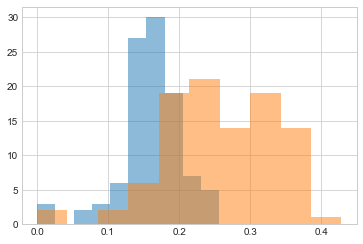

In [1576]:
sms_low_age = getrate(['SMS_received','Age'])
#sms_low_age = low_age.groupby(['SMS_received','Age'])['No-show'].sum() / low_age.groupby(['SMS_received','Age'])['No-show'].count()
sms_low_age[0].hist(alpha=0.5);
sms_low_age[1].hist(alpha=0.5);

Receiving SMS seems to correlate more with rates of no-show in the lower age

<a id='conclusions'></a>
## Conclusions

In general, most appointments have some sort of delay, however no-show is marked for only a portion of these. It seems many patients do modifications on the original schedule. No-show in a few poccasions also applied also to patients who came one or more days earlier than their appointment.

It seems there are some characteristics which correlate to high noshow rates and can be used to predcit a pateint missing the appointment.

- Some patients have a consistent history of no-show, no-show is expected if the patient is one of those. 
- Ages between 9 and 30 have the highest frequency of no-show rates.
- Patients who have the Bolsa Familia scholarship show a higher rate of no-show.
- Patients with disease such as hyper-tension, diabetes or not sverely handicapped show less rate of no-shows. 
- Patientes with high severity of bieng handicapped have high no-show rates.
- In certain neighbourhoods, higher rate of no-shows was observed compared to other neighbourhoods.

- On the other hand, Gender and Alcoholism have apparently no correaltion to no-show rates.

Receiving SMS reminders surprisngly correlates with increase in no-show rate. It is not very clear if receving SMS has affected patients with certian characteristics stronger than others but it seems to have a higher impact on lower ages as per the analysis.


### Limitations

Some characteristics appeared only in few appointemtns which might be not enough to conclude. For example, a neighbourhood was found to have only one appointment.

It is also woth noting that the analysis was performed only using the provided data and assuming the meaning of 1 for the presense of the patient characteristic. 2-4 values were also assumed as severity for being handicapped. 

Unknown factors may have affected the no-show rates and not provided such as for example weather or traffic conditions.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [1577]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0